In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, add, multiply
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import concatenate, Activation
from keras import backend as K

import tensorflow as tf

### Prediction Function

In [56]:
def prediction_nucleus(model_path, X_test, img_size = (256, 256), thres = 0.5, verbose = 1):
    # Predict on train, val and test
    model = load_model(model_path)
    preds_test = model.predict(X_test, verbose=verbose)

    # Threshold predictions
    preds_test_t = (preds_test > thres).astype(np.uint8)

    # Create list of upsampled test masks
    preds_test_upsampled = []
    for i in range(len(preds_test_t)):
        preserve = np.squeeze(preds_test_t[i])
        res = resize(preserve, img_size, mode='constant', preserve_range=True)
        preds_test_upsampled.append(res.astype(np.uint8))
    return preds_test_upsampled

### Watershed for nucleus split

In [40]:
import cv2
import scipy.ndimage as ndi
from skimage.segmentation import watershed, find_boundaries
from skimage.feature import corner_peaks
from skimage.morphology import binary_dilation, disk
from skimage.color import label2rgb
from skimage.measure import regionprops_table

def make_boundary_image(L, A, thickness=1, color=(255,255,85), rescale_hist=True):
    if A.ndim == 2:
        A = np.stack((A,A,A), axis=2)
    if rescale_hist:
        A = np.interp(A, (np.amin(A), np.amax(A)), (0,255)).astype(np.uint8)
    else:
        A = A.astype(np.uint8)

    mask = find_boundaries(L)
    mask = binary_dilation(mask, footprint=disk(thickness))

    R = A[:,:,0].copy()
    G = A[:,:,1].copy()
    B = A[:,:,2].copy()

    R[mask] = color[0]
    G[mask] = color[1]
    B[mask] = color[2]

    return np.stack((R,G,B), axis=2)

def labelvis(A, L, bg_color='b'):
    bg_color_code = {
        'b': (0.1,0.1,0.5),
        'g': (0.1,0.5,0.1),
    }  
    A = label2rgb(L, A, bg_label=0, bg_color=bg_color_code[bg_color], alpha=0.3, image_alpha=1)
    A = np.interp(A, (0,1), (0,255)).astype(np.uint8)
    A = make_boundary_image(L, A)
    return A

# Create predict boundary image with label
# Input: image, label
# Output: rgb_watershed, boundary, mask, dataframe
def create_boundary(img, label):
    #Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
    ret1, thresh = cv2.threshold(label, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Borrow from imageMKS
    # Step 9: distance transform
    distance = ndi.distance_transform_edt(thresh)
    
    # Step 10: mark the maxima in the distance transform and assign labels
    peak_markers = corner_peaks(distance, min_distance=5, indices=False)
    peak_markers = ndi.label(peak_markers)[0]
    
    # Step 11: separate touching nuclei using the watershed markers
    markers = watershed(label, peak_markers, mask=label)
    
    # Step 13: reassigning labels, so that they are continuously numbered
    old_labels = np.unique(markers)
    for i in range(len(old_labels)):
        markers[markers == old_labels[i]] = i
    
    #Let us color boundaries in yellow. 
    img[markers == -1] = [0,255,255]  
    
    img_rgb = label2rgb(markers, bg_label=0)
    boundary = labelvis(img, markers)
    
    # regionprops function in skimage measure module calculates useful parameters for each object.
    params = ['label', 'area', 'bbox', 'equivalent_diameter', 'mean_intensity', 'solidity']
    props = regionprops_table(markers, intensity_image=X_test[0], properties=params)
    df = pd.DataFrame(props)
    
    return img_rgb, boundary, markers, df

In [41]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'dataset/stage1_train/'
TEST_PATH = 'dataset/stage1_test/'

dir_path = ''

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

os.getcwd()

'/Users/cusniwtt/Documents/GitHub/unet-nucleus'

## Get Test data

In [42]:
# Get train and test IDs
#train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [43]:
# Get and resize train images and masks
"""
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    #Read image files iteratively
    path = TRAIN_PATH + id_
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for train dataset
    X_train[n] = img
    
    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    
    #Looping through masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:

        # Remove .DS_Store file
        if mask_file == '.DS_Store':
            continue
        
        #Read individual masks
        mask_ = imread(dir_path + path + '/masks/' + mask_file)
        
        #Expand individual mask dimensions
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)

        #Overlay individual masks to create a final mask for corresponding image
        try:
            mask = np.maximum(mask, mask_)
        except:
            print(mask_file)
    
    #Append mask to numpy array for train dataset
    Y_train[n] = mask
"""

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    
    #Read images iteratively
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    
    #Get test size
    sizes_test.append([img.shape[0], img.shape[1]])
    
    #Resize image to match training data
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for test dataset
    X_test[n] = img

    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    
    #Looping through masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:

        # Remove .DS_Store file
        if mask_file == '.DS_Store':
            continue
        
        #Read individual masks
        mask_ = imread(dir_path + path + '/masks/' + mask_file)
        
        #Expand individual mask dimensions
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)

        #Overlay individual masks to create a final mask for corresponding image
        try:
            mask = np.maximum(mask, mask_)
        except:
            print(mask_file)
    
    #Append mask to numpy array for train dataset
    Y_test[n] = mask

print('Done!')

Getting and resizing test images ... 


100%|██████████| 12/12 [00:01<00:00, 11.42it/s]

Done!


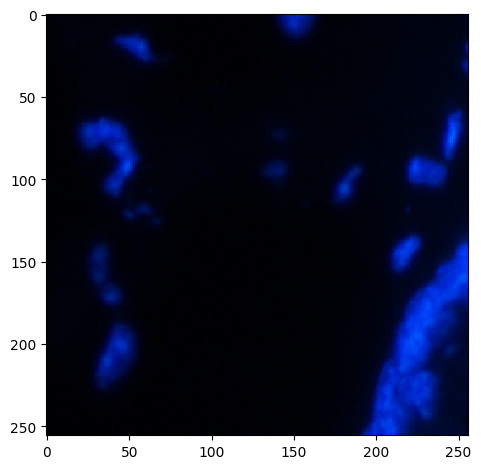

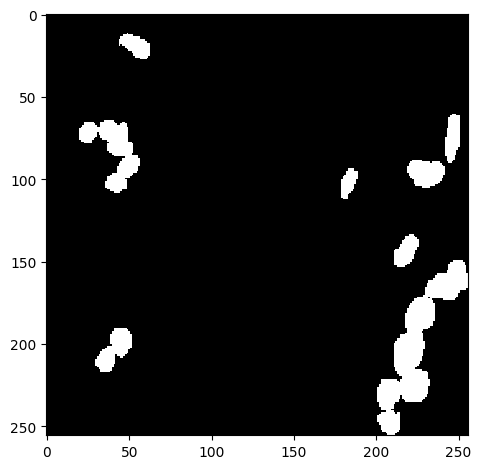

In [53]:
# Check if training data looks all right
#ix = random.randint(0, len(train_ids))
imshow(X_test[0])
plt.show()
imshow(np.squeeze(Y_test[0]))
plt.show()

# Prediction

## U-Net 64

### Adam, BCE

In [57]:
w_path = 'weights/unet_64_adam_bce_8.h5'
Y_pred = []
for i in range(X_test.shape[0]):
    pred = prediction_nucleus(model_path=w_path, X_test=X_test[i])
    Y_pred.append(pred)
    print(test_ids[i])
Y_pred = np.array(Y_pred)
Y_pred.shape

ValueError: in user code:

    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 1845, in predict_function  *
        return step_function(self, iterator)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 1834, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 1823, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/training.py", line 1791, in predict_step
        return self(x, training=False)
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/cusniwtt/opt/miniconda3/envs/tf2.9/lib/python3.9/site-packages/keras/engine/input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "unet" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(32, 256, 3)


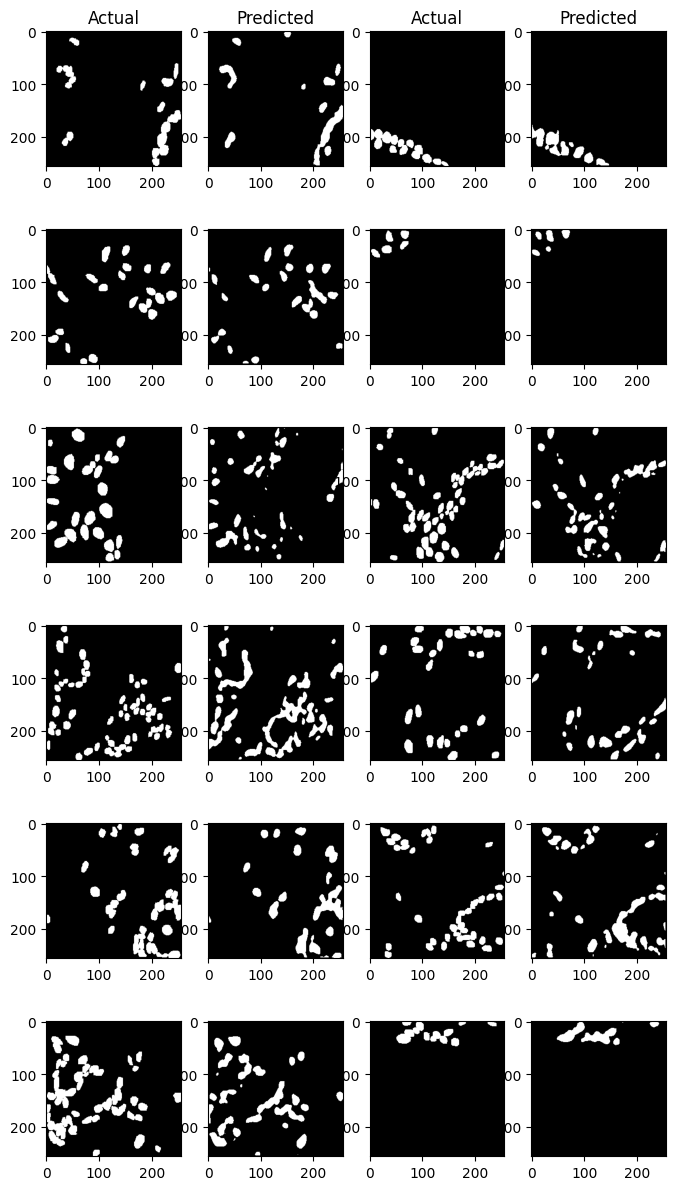

In [29]:
fig, axs = plt.subplots(6, 4, figsize=(8, 15))
row = 0
col = 0
for i in range(X_test.shape[0]):
  axs[row][col].imshow(Y_test[i], cmap='gray')
  axs[row][col+1].imshow(np.squeeze(Y_pred[i]), cmap='gray')
  col = col + 2
  if col == 4:
    col = 0
    row = row + 1
axs[0][0].set_title('Actual')
axs[0][1].set_title('Predicted')
axs[0][2].set_title('Actual')
axs[0][3].set_title('Predicted')
plt.show()